# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import module

In [2]:
os.getcwd()

'c:\\Users\\Pierrick\\OneDrive\\Bureau\\K\\2_MS_TelecomParis\\Cours\\Projet_Fil_Rouge\\Activity_Detection_From_Electrical_Consumption_Load_Curves\\Exploratory Data Analysis'

In [3]:
# we load house 1
house1_power_blk2 = module.load_dataset('data/house1_power_blk2_labels.zip')

# we load house 2
house2_power_blk1 = module.load_dataset('data/house2_power_blk1_labels.zip')

In [4]:
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [5]:
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


# Analysis

### EDA df_house

1. Infos sur la dataframe<br>
    a. Nombre de lignes<br>
    b. Nombre de jours, premier jour, dernier jour<br>
    c. Proportion d'activité<br>
    d. Périodes d'activité<br>
        d.1 Nombre de périodes moyen par jour<br>
        d.2 Durée moyenne d'une période activité et non activité<br>

2. Affichage<br>
    a. Activité / non activité pour des jours aléatoires<br>
    b. Swarmplot (ou BoxPlot/ViolinPlot) des durées de périodes d'activité<br>
    c. Nombre de périodes d'activité par jour au fil du temps

#### Fonctions

In [6]:
def activity_ratio(df_house):
    activity, counts = np.unique(df_house['activity'], return_counts = True)
    return (counts[np.where(activity == 1)[0]] / np.sum(counts))[0]

In [7]:
def detect_stages(house):
    """
    Transforme une dataframe de time series en une dataframe des périodes
    Args :
        -df_house : dataframe avec index datetime et une colonne activity
    Return :
        - df_stages : dataframe avec pour chaque ligne une période : (début, fin, durée, activity)
    """
    df_house=house.copy()
    df_house["next_activity"] = df_house["activity"].shift(1)
    df_house["next_activity"]=df_house["next_activity"].fillna(method="bfill").astype(int)
    df_house["switch_activityLvl"] = np.where(df_house["next_activity"]==df_house["activity"], 0, 1)
    df_house["stage"]=df_house["switch_activityLvl"].cumsum()
    df_house=df_house.reset_index().groupby(by='stage').agg({"activity" : ['mean'], "datetime": ['min', 'max']})
    df_house.columns = ['_'.join(col) for col in df_house.columns.values]
    df_house=df_house.rename(columns={"activity_mean": "activity"})
    df_house["activity"]=df_house["activity"].astype(int)
    df_house["duration_min"]=(df_house["datetime_max"]-df_house["datetime_min"]).astype("timedelta64[m]")
    df_house["duration_sec"]=(df_house["datetime_max"]-df_house["datetime_min"]).astype("timedelta64[s]")
    return df_house

#### Plots

In [8]:
# Choose dataframe
df_house = house1_power_blk2

Nombre de lignes dans la dataframe :  5439600
Pourcentage d'activité :  0.4765852268549158
Premier jour : 2016-03-06,  dernier jour : 2016-05-07, durée : 62 jours


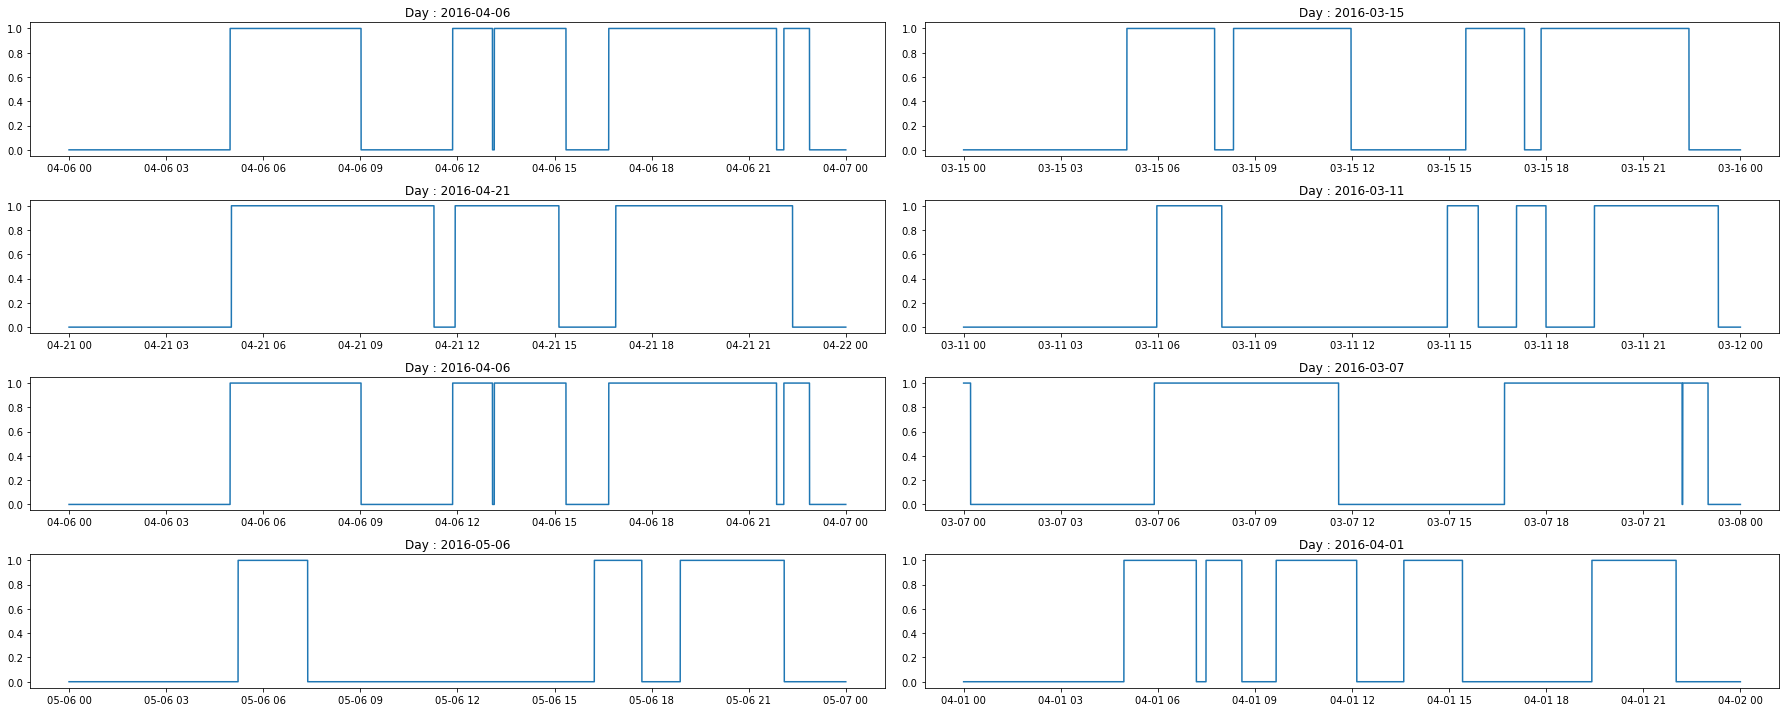

In [9]:
print("Nombre de lignes dans la dataframe : ", len(df_house))
print("Pourcentage d'activité : ", activity_ratio(df_house))
print("Premier jour : {},  dernier jour : {}, durée : {} jours".format(min(df_house.index.date), max(df_house.index.date), (max(df_house.index)- min(df_house.index)).days))

fig, ax = plt.subplots(4,2)
fig.set_size_inches((25,10))
for i in range(4):
    for j in range(2):
        random_day = df_house.sample(1).index.date[0]
        ax[i, j].plot(df_house[df_house.index.date == random_day].index, df_house[df_house.index.date == random_day]["activity"])
        ax[i, j].set_title("Day : " + str(random_day))
fig.tight_layout()

,activity,datetime_min,datetime_max,duration_min,duration_sec
stage,,,,,
0,0,2016-03-06 00:00:00,2016-03-06 06:41:40,401.0,24100.0
1,1,2016-03-06 06:41:41,2016-03-06 08:46:49,125.0,7508.0


Nombre de périodes : 501 dont 250 d'activité et 251 d'inactivité
Nombre moyen de périodes d'activité par jour :  4.03
Durée moyenne d'une période d'activité : 172.344 , écart-type : 121.23723658239886
Durée moyenne d'une période d'inactivité : 188.52988047808765 , écart-type : 170.16150593946222


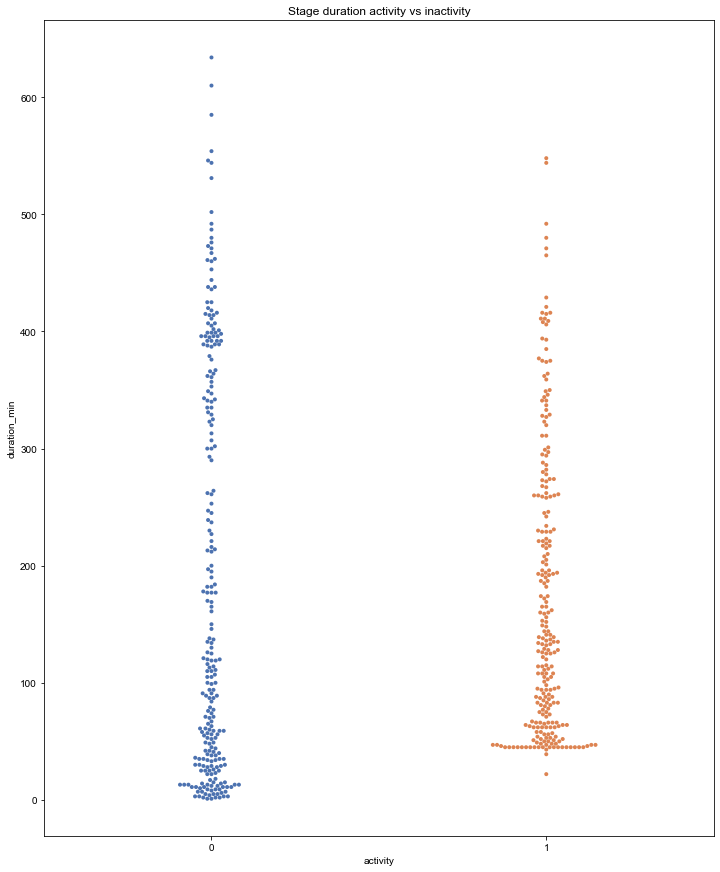

In [10]:
fig, ax = plt.subplots(figsize=(12,15))
df = detect_stages(df_house)
display(df.head(2))
sns.set_theme(style="whitegrid")
ax = sns.swarmplot(x=df["activity"], y=df['duration_min'], size=4)
ax.set_title("Stage duration activity vs inactivity")
print("Nombre de périodes : {} dont {} d'activité et {} d'inactivité".format(len(df),len(df[df["activity"]==1]), len(df[df["activity"]==0])))
print("Nombre moyen de périodes d'activité par jour : ", round(len(df[df["activity"]==1])/(max(df.datetime_max)- min(df.datetime_min)).days, 2))
print("Durée moyenne d'une période d'activité : {} , écart-type : {}".format(df[df["activity"]==1]["duration_min"].mean(), df[df["activity"]==1]["duration_min"].std()))
print("Durée moyenne d'une période d'inactivité : {} , écart-type : {}".format(df[df["activity"]==0]["duration_min"].mean(), df[df["activity"]==0]["duration_min"].std()))
del df

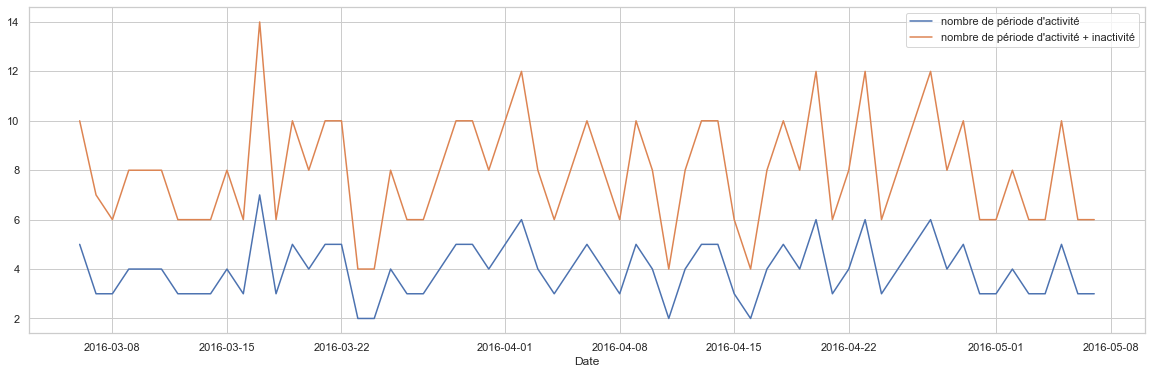

In [11]:
df = detect_stages(df_house)
df["date"] = df["datetime_min"].dt.date

df = df.groupby('date').agg({"activity" : ["count", "sum"]})
plt.figure(figsize=(20,6))
plt.plot(df.index, df["activity"]["sum"], label = "nombre de période d'activité")
plt.plot(df.index, df["activity"]["count"], label = "nombre de période d'activité + inactivité")
plt.legend()
plt.xlabel("Date")
del df

In [12]:
del df_house

# Model

Découper une dataframe en période de temps -> utiliser df.cut()<br> 
Sous échantilloner si besoin pour accélérer les calculs -> utiliser df.resample()<br>
Régression ou classification : label soit %activité sur la période, soit 0/1<br>

In [13]:
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [14]:
duration=5*60
df_house = house1_power_blk2

date_inf = min(df_house.index)

In [15]:
date_inf

Timestamp('2016-03-06 00:00:00', freq='S')

In [16]:
date_sup = date_inf + datetime.timedelta(seconds = duration)
date_sup

Timestamp('2016-03-06 00:05:00', freq='S')

In [18]:
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [ ]:
def segmentDf(df_house, duration=5*60, overlap=0):
    """
    Créer des times series courtes à partir d'une time serie unique
    Args :
        - df_house : dataframe contenant une colonne activity, mains (load) et datetime en index
        - duration : durée de chaque time serie en secondes
        - overlap : pourcentage d'overlapping pour chaque time serie
    Return :
        - une liste de tuple (time_series, label) avec time_series la séquence des puissances (mains) et label le pourcentage d'activité pendant la période
    """
    

In [ ]:

def binarizeSegmentedDf(df, threshold):
    """
    
    """